# Ward Life Expectancies

Group project done by [Cillian](https://github.com/cjber), [James](https://github.com/jammy-data), [Hope](https://www.linkedin.com/in/hope-bleasdale-a27395173/), and [Peter](https://github.com/peterprescott), for the [Manchester](https://www.manchester.ac.uk/) module of the [Data Analytics MSc/PhD](https://datacdt.org/).

I recommend that you install the [Table of Contents Notebook Extension](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/toc2/README.html) so that you can navigate around this document with maximum ease.

## Task
>You will find five files providing various ward level data for London on blackboard. 
>
>Your task is to obtain/to build **a model which predicts life expectancy at the ward level**.  
>
>To do this you will need to:
>
>1. review the data, 
>2. consider which files you are going to use. 
>3. Think about what you are going to do about any missing values. 
>4. You may want to combine variables together for example to create some sort of index of deprivation as a predictor. 
>5. You may want to standardise variables.

## Review the Data

Note that underscores have been added to the filenames using [detox](https://github.com/dharple/detox).

In [1]:
import pandas as pd # for data manipulation
import matplotlib.pyplot as plt # for visualization
import numpy as np
import os.path

### Code Conversion Table

In [2]:
codes = pd.read_csv(os.path.join('data','London_District_codes.csv'))
print(codes.shape)
codes.head(1)

(32, 2)


,District,Districtcode
0,Barking and Dagenham,00AB


In [3]:
codes.Districtcode.unique()

array([' 00AB', ' 00AC', ' 00AD', ' 00AE', ' 00AF', ' 00AG', ' 00AH',
       ' 00AJ', ' 00AK', ' 00AL', ' 00AM', ' 00AN', ' 00AP', ' 00AQ',
       ' 00AR', ' 00AS', ' 00AT', ' 00AU', ' 00AW', ' 00AX', ' 00AY',
       ' 00AZ', ' 00BA', ' 00BB', ' 00BC', ' 00BD', ' 00BE', ' 00BF',
       ' 00BG', ' 00BH', ' 00BJ', ' 00BK'], dtype=object)

`London_District_codes.csv` is a simple CSV conversion table of district names and codes for London's 32 boroughs. The `Districtcode` is a string of two zeroes, followed by two capital letters. We will clean the data by removing the spaces from the front of each `Districtcode`.

In [4]:
codes['Districtcode'] = codes['Districtcode']\
    .replace(r'\s', '', regex=True)
codes.Districtcode.unique()

array(['00AB', '00AC', '00AD', '00AE', '00AF', '00AG', '00AH', '00AJ',
       '00AK', '00AL', '00AM', '00AN', '00AP', '00AQ', '00AR', '00AS',
       '00AT', '00AU', '00AW', '00AX', '00AY', '00AZ', '00BA', '00BB',
       '00BC', '00BD', '00BE', '00BF', '00BG', '00BH', '00BJ', '00BK'],
      dtype=object)

### Socio-economic Data

In [5]:
# jupyter magic to call from command line
! conda install pyreadstat

Solving environment: ...working... done

# All requested packages already installed.



In [6]:
socio = pd.read_spss(os.path.join('data','London_ward_data_socioeconomic.sav'))
print(socio.shape)
socio.head(1)

(657, 5)


,Wardcode,hhSocialRented,JobSeekers,Noqual,Carsperhousehold
0,00ABFX,26.7,8.7,16.4,0.5


In [7]:
len(socio.Wardcode.unique())

622

In [8]:
socio.Wardcode.describe()

count     657
unique    622
top          
freq       36
Name: Wardcode, dtype: object

In [9]:
socio = socio.loc[socio.Wardcode!=""]
print(socio.shape)
socio.Wardcode.describe()

(621, 5)


count        621
unique       621
top       00ATGA
freq           1
Name: Wardcode, dtype: object

`London_ward_data_socioeconomic.sav` is an [SPSS](https://www.ibm.com/uk-en/analytics/spss-statistics-software) file, which means we need to install `pyreadstat` to read it. After removing null values, we see that it contains socioeconomic data for 621 wards, with a `Wardcode` identifier made up of two zeroes followed by four capital letters (the first two letters presumably correspond to the ward's `Districtcode`), and values for four attributes of the ward: the percentage of households that are social-rented (`hhSocialRented`), the percentage of the population that is seeking employment (`JobSeekers`), the percentage of the population that has no qualifications (`Noqual`), and the mean number of cars per household (`Carsperhousehold`).

In [10]:
def plot_features(df):
    """Plot KDE for all features in given dataset.
    
    Args:
        df (pandas dataframe)
    """
    n = len(df.columns) - 1
    
    fig, axs = plt.subplots(1,n, figsize=(20,3))

    for i, col in enumerate(df.columns[1:]):
        ax=axs[i]
        ax.set_title(col, loc='left')
        df[col].plot.kde(ax=ax)

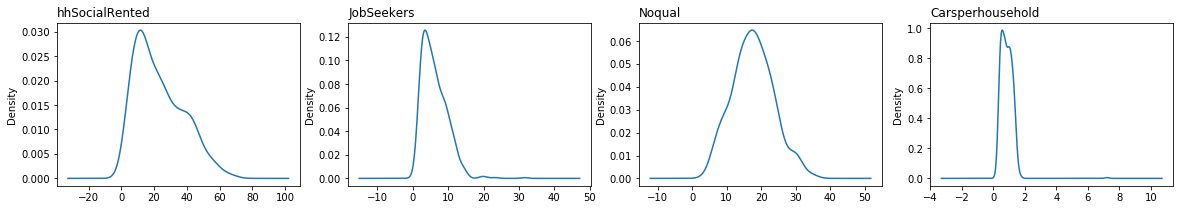

In [11]:
plot_features(socio)

### Environment Data

In [12]:
env = pd.read_csv(os.path.join('data','London_ward_data_environment.csv'))
print(env.shape)
env.head(1)

(624, 4)


,Wardcode,Population2011Census,Crimerate,Openspace
0,00ANGQ,11201,117.7,0.0


In [13]:
env.Crimerate.describe()

count     624.000000
mean      100.173718
std       114.498432
min         0.900000
25%        64.050000
50%        84.750000
75%       107.450000
max      2100.200000
Name: Crimerate, dtype: float64

In [14]:
env.Openspace.describe()

count    624.000000
mean      27.273077
std       17.821577
min        0.000000
25%       13.800000
50%       23.750000
75%       36.925000
max       99.900000
Name: Openspace, dtype: float64

`London_ward_data_environment.csv` is a CSV file containing what it calls 'environment' data for 624 wards, each again with the `Wardcode` identifier, and then with three attributes: the population as recorded in the 2011 Census (`Population2011Census`), this is an integer; a crime rate indicator (`Crimerate`) which looks like it has been standardized so the mean is 100, and the minimum is just over zero; and a value showing what percentage of the ward's surface area is classified as open space.

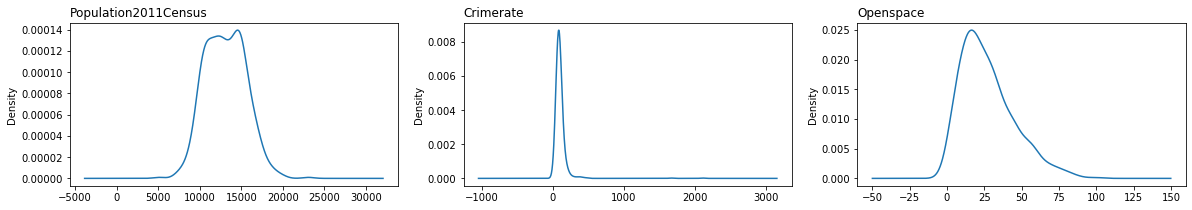

In [15]:
plot_features(env)

### Health Data

In [16]:
health = pd.read_sas(os.path.join('data','london_ward_data_health.sas7bdat'),
                     format='sas7bdat', encoding='latin1')
print(health.shape)
health.head(1)

(622, 5)


,Wardname,Population2011Census,GeneralFertilityRate,Malelifeexpectancy,Femalelifeexpectancy
0,Bromley - Darwin,5110.0,63.8,81.2,82.4


`london_ward_data_health.sas7bdat` is an SAS file, with rows for 622 wards which are identified by `Wardname`, each with four other features: population as recorded in the 2011 Census (`Population2011Census`), the `GeneralFertilityRate`, the `Malelifeexpectancy`, and the `Femalelifeexpectancy`.

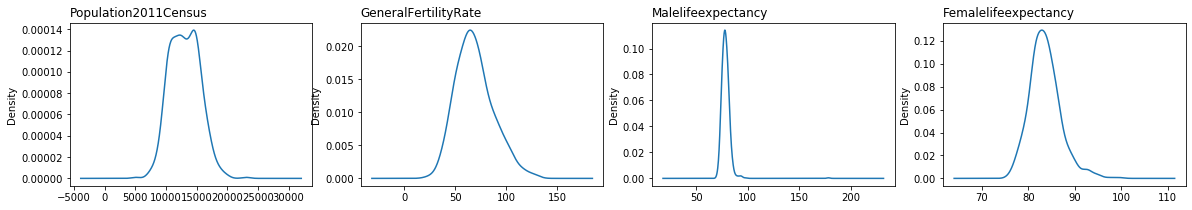

In [17]:
plot_features(health)

Our plot suggests that `Malelifeexpectancy` has an erroneous outlier.

In [18]:
health[['Wardname','Malelifeexpectancy']].sort_values('Malelifeexpectancy', ascending=False).head(1)

,Wardname,Malelifeexpectancy
68,Sutton - Wallington South,178.0


On inspection this turns out to be `Sutton - Wallington South`, where apparently an average male can expect 178.0 years of life. Since there are no other missing values, it seems most likely to me that what has happened here is that an extra 1 has somehow been added to the front of a figure of `78.0`. We can correct this accordingly.

In [19]:
health.iloc[68] = (health.iloc[68][0], health.iloc[68][1], health.iloc[68][2], 78, health.iloc[68][4])
health.loc[[68]]

,Wardname,Population2011Census,GeneralFertilityRate,Malelifeexpectancy,Femalelifeexpectancy
68,Sutton - Wallington South,10200.0,53.0,78.0,81.7


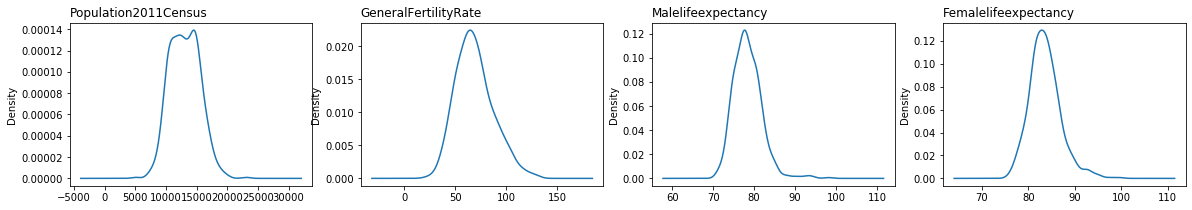

In [20]:
plot_features(health)

### Demographic Data

In [21]:
demo = pd.read_csv(os.path.join('data','London_ward_data_demographics.dat'), delimiter='\t')
print(demo.shape)
demo.head(1)

(623, 6)


,Wardname,Children,Greaterthan65,nonwhite,NotBorninUK,NotEnglishspeaking
0,Hackney - Queensbridge,17.542063,8.2,44.7,38.3,11.8


`London_ward_data_demographics.dat` is a tab-separated text-file, containing demographic data for 623 wards, which are also identified by a `Wardname`, each with five other features which all appear to be percentages: `Children` is presumably the percentage of households in the ward with children; `Greaterthan65`, `nonwhite`, `NotBorninUK`, and `NotEnglishspeaking` are presumably the percentages of individuals in the ward with those characteristics.

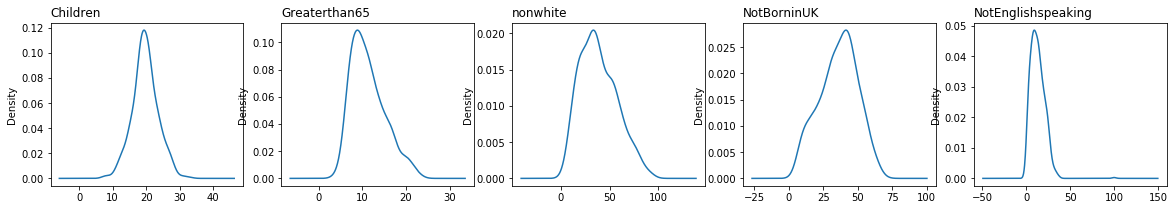

In [22]:
plot_features(demo)

## Combining the Datasets

### Create `Districtcode` column from `Wardcode`

### Merge `socio` and `env` datasets on shared `Wardcode`

We then merge the Socio-Economic Dataset with the Environment dataset on their shared `Wardcode`.

In [23]:
socio_env = pd.merge(socio, env, on='Wardcode')
print(socio.shape, env.shape, socio_env.shape)
socio_env.head(1)

(621, 5) (624, 4) (619, 8)


,Wardcode,hhSocialRented,JobSeekers,Noqual,Carsperhousehold,Population2011Census,Crimerate,Openspace
0,00ABFX,26.7,8.7,16.4,0.5,12786,172.5,19.6


Unfortunately, we seem to have lost two wards in the merge. Let's try and see why.

In [24]:
lost_from_env = set(env.Wardcode.unique()).difference(set(socio_env.Wardcode.unique()))
lost_from_socio = set(socio.Wardcode.unique()).difference(set(socio_env.Wardcode.unique()))

In [25]:
print(lost_from_env)
print(lost_from_socio)

{'00ABGA', '00AYGF', '00AGGK', '00BGGB', '00BAGDag'}
{'00AGGK#', '00BAGD'}


That explains it -- two `Wardcodes` have extra characters at the end. We can fix that.

In [26]:
env.loc[env.Wardcode=='00BAGDag']

,Wardcode,Population2011Census,Crimerate,Openspace
126,00BAGDag,9816,61.0,12.3


In [27]:
env.iloc[126] = ('00BAGD', env.iloc[126][1], env.iloc[126][2], env.iloc[126][3])
env.loc[[126]]

,Wardcode,Population2011Census,Crimerate,Openspace
126,00BAGD,9816,61.0,12.3


In [28]:
socio.loc[socio.Wardcode=='00AGGK#']

,Wardcode,hhSocialRented,JobSeekers,Noqual,Carsperhousehold
107,00AGGK#,45.9,6.3,17.8,0.5


In [29]:
socio.iloc[107] = ('00AGGK', socio.iloc[107][1], socio.iloc[107][2], socio.iloc[107][3], socio.iloc[107][4])
socio.loc[[107]]

,Wardcode,hhSocialRented,JobSeekers,Noqual,Carsperhousehold
107,00AGGK,45.9,6.3,17.8,0.5


In [30]:
socio.loc[[107]]

,Wardcode,hhSocialRented,JobSeekers,Noqual,Carsperhousehold
107,00AGGK,45.9,6.3,17.8,0.5


In [31]:
socio_env = pd.merge(socio, env, on='Wardcode')
print(socio.shape, env.shape, socio_env.shape)
socio_env.head(1)

(621, 5) (624, 4) (621, 8)


,Wardcode,hhSocialRented,JobSeekers,Noqual,Carsperhousehold,Population2011Census,Crimerate,Openspace
0,00ABFX,26.7,8.7,16.4,0.5,12786,172.5,19.6


Now we seem to have merged those two datasets without losing any data.

### Merge `health` and `demo` datasets on shared `Wardname`

In [32]:
health_demo = pd.merge(health, demo, on='Wardname')
print(health.shape, demo.shape, health_demo.shape)
health_demo.head(1)

(622, 5) (623, 6) (518, 10)


,Wardname,Population2011Census,GeneralFertilityRate,Malelifeexpectancy,Femalelifeexpectancy,Children,Greaterthan65,nonwhite,NotBorninUK,NotEnglishspeaking
0,Bromley - Darwin,5110.0,63.8,81.2,82.4,18.317025,21.9,4.8,6.1,0.4


Oh dear, we've lost more than a hundred wards in that merge. Let's look at the ones that were lost and try and see why.

In [33]:
print(set(demo.Wardname.unique()).difference(set(health_demo.Wardname.unique())))

{'Kensington & Chelsea - Campden', "Islington - Saint Peter's", 'Barking & Dagenham - Whalebone', 'Hounslow - Osterley & Spring Grove', 'Hammersmith & Fulham - Wormholt & White City', 'Tower Hamlets - Blackwall & Cubitt Town', "Hammersmith & Fulham - Shepherd's Bush Green", 'Kensington & Chelsea - Holland', 'Kensington & Chelsea - Cremorne', 'Kensington & Chelsea - Royal Hospital', 'Camden - Holborn & Covent Garden', 'Redbridge - Loxford', 'Richmond upon Thames - Mortlake & Barnes Common', 'Hammersmith & Fulham - North End', "Bexley - Saint Michael's", 'Tower Hamlets - East India & Lansbury', "Kensington & Chelsea - Queen's Gate", "Wandsworth - Saint Mary's Park", 'Barking & Dagenham - Heath', 'Bromley - Plaistow & Sundridge', 'Havering - Rainham & Wennington', 'Sutton - Carshalton South & Clockhouse', 'Croydon - Selsdon & Ballards', 'Barking & Dagenham - Mayesbrook', 'Hammersmith & Fulham - Fulham Reach', 'Kensington & Chelsea - Redcliffe', "Tower Hamlets - Saint Dunstan's & Stepney G

Many seem to have ampersands ('&') in their names -- we can change that.

In [34]:
# replace '&' with 'and'
demo['Wardname'] = demo['Wardname'].str.replace('&', 'and')

In [35]:
# try merging again
health_demo = pd.merge(health, demo, on='Wardname')
print(health.shape, demo.shape, health_demo.shape)
health_demo.head(1)

(622, 5) (623, 6) (601, 10)


,Wardname,Population2011Census,GeneralFertilityRate,Malelifeexpectancy,Femalelifeexpectancy,Children,Greaterthan65,nonwhite,NotBorninUK,NotEnglishspeaking
0,Bromley - Darwin,5110.0,63.8,81.2,82.4,18.317025,21.9,4.8,6.1,0.4


Better, but we're still missing twenty-one wards. Let's look again.

In [36]:
print(set(demo.Wardname.unique()).difference(set(health_demo.Wardname.unique())))

print(set(health.Wardname.unique()).difference(set(health_demo.Wardname.unique())))

{"Islington - Saint Peter's", 'Sutton - Saint Helier', 'Camden - Saint Pancras and Somers Town', "Westminster - Saint James's", "Haringey - Saint Ann's", 'Redbridge - Loxford', 'Merton - Saint Helier', "Bexley - Saint Mary's", 'Kensington and Chelsea - Saint Charles', "Islington - Saint George's", "Bexley - Saint Michael's", "Islington - Saint Mary's", "Kingston upon Thames - Saint Mark's", 'Richmond upon Thames - Saint Margarets and North Twickenham', "Havering - Saint Andrew's", "Tower Hamlets - Saint Katherine's and Wapping", "Wandsworth - Saint Mary's Park", "Tower Hamlets - Saint Dunstan's and Stepney Green", 'Richmond upon Thames - Ham, Petersham and Richmond Riverside', 'Kingston upon Thames - Saint James', "Lambeth - Saint Leonard's", 'Lambeth - Stockwell'}
{"Wandsworth - St. Mary's Park", 'Camden - St. Pancras and Somers Town', "Islington - St. George's", "Lambeth - St. Leonard's", "Havering - St. Andrew's", 'Sutton - St. Helier', "Tower Hamlets - St. Katherine's and Wapping",

Looks like 'St.' has been expanded to 'Saint' -- let's undo that.

In [37]:
# replace 'Saint' with 'St.'
demo['Wardname'] = demo['Wardname'].str.replace('Saint', 'St.')

In [38]:
# try merging again
health_demo = pd.merge(health, demo, on='Wardname')
print(health.shape, demo.shape, health_demo.shape)
health_demo.head(1)

(622, 5) (623, 6) (619, 10)


,Wardname,Population2011Census,GeneralFertilityRate,Malelifeexpectancy,Femalelifeexpectancy,Children,Greaterthan65,nonwhite,NotBorninUK,NotEnglishspeaking
0,Bromley - Darwin,5110.0,63.8,81.2,82.4,18.317025,21.9,4.8,6.1,0.4


Almost there, but we're still losing some wards.

In [39]:
print(set(demo.Wardname.unique()).difference(set(health_demo.Wardname.unique())))

print(set(health.Wardname.unique()).difference(set(health_demo.Wardname.unique())))

{'Richmond upon Thames - Ham, Petersham and Richmond Riverside', 'Redbridge - Loxford', 'Richmond upon Thames - St. Margarets and North Twickenham', 'Lambeth - Stockwell'}
{'Sutton - The Wrythe', 'Richmond upon Thames - Ham, Petersham & Richmond Riverside', 'Richmond upon Thames - St. Margarets & North Twickenham'}


Ah -- we changed the ampersands to 'ands' in the `demo` dataframe but not in the `health` one. If we do that then the other differences are all genuinely different wards.

In [40]:
# replace '&' with 'and'
health['Wardname'] = health['Wardname'].str.replace('&', 'and')

# merge again, this time with an 'outer join' so that we get the union of both sets, instead of just the intersection; 
# this means we will have some null values, but we're not losing anything.
health_demo = pd.merge(health, demo, on='Wardname', how='outer')
print(health.shape, demo.shape, health_demo.shape)
health_demo.head(1)

(622, 5) (623, 6) (624, 10)


,Wardname,Population2011Census,GeneralFertilityRate,Malelifeexpectancy,Femalelifeexpectancy,Children,Greaterthan65,nonwhite,NotBorninUK,NotEnglishspeaking
0,Bromley - Darwin,5110.0,63.8,81.2,82.4,18.317025,21.9,4.8,6.1,0.4


### Separate `Wardname` into distinct names of `District` and `Ward`

In [41]:
## health_demo[['District','Ward']] = health_demo['Wardname'].str.split('-', expand=True)

We should be able to separate the names of the District and the Ward on the hyphen, but this throws a `ValueError: Columns must be same length as key`. We can keep adding `overflow` columns to deal with this and then examine what the problem was.

In [42]:
health_demo[['District','Ward','overflow1','overflow2']] = health_demo['Wardname'].str.split('-', expand=True)

In [43]:
health_demo.overflow1.unique()

array([None, 'by'], dtype=object)

In [44]:
health_demo.overflow2.unique()

array([None, 'Bow'], dtype=object)

Looks like we were tripped up a  little by the hyphens in Bromley-by-Bow. 

But if we include the spaces either side of the hyphen, in our instruction to split the wardname, then it should work.

In [45]:
health_demo[['District','Ward']] = health_demo['Wardname'].str.split(' - ', expand=True)

In [46]:
health_demo = health_demo.drop(['overflow1'], axis=1)\
                        .drop(['overflow2'],axis=1)

In [47]:
health_demo.head(1)

,Wardname,Population2011Census,GeneralFertilityRate,Malelifeexpectancy,Femalelifeexpectancy,Children,Greaterthan65,nonwhite,NotBorninUK,NotEnglishspeaking,District,Ward
0,Bromley - Darwin,5110.0,63.8,81.2,82.4,18.317025,21.9,4.8,6.1,0.4,Bromley,Darwin


### Create `Districtcode` from `Wardcode` and create District-Level Dataset

 We could use our observation that the the first two letters of the `Wardcode` identifier presumably correspond to the ward's `Districtcode` to create a separate `Districtcode` column for each ward in the Socio-Economic Dataset.

In [48]:
socio_env['Districtcode'] = socio_env['Wardcode'].str[:-2]
socio_env = socio_env.merge(codes, on='Districtcode')

This allows us to create a combined district-level dataset with information for all the variables.

In [49]:
districts = pd.merge(socio_env.groupby('District').mean(), health_demo.groupby('District').mean(), on='District')

print(socio_env.groupby('District').mean().shape, health_demo.groupby('District').mean().shape, districts.shape)
print(list(districts.columns))
districts.head(1)

(32, 7) (32, 9) (32, 16)
['hhSocialRented', 'JobSeekers', 'Noqual', 'Carsperhousehold', 'Population2011Census_x', 'Crimerate', 'Openspace', 'Population2011Census_y', 'GeneralFertilityRate', 'Malelifeexpectancy', 'Femalelifeexpectancy', 'Children', 'Greaterthan65', 'nonwhite', 'NotBorninUK', 'NotEnglishspeaking']


,hhSocialRented,JobSeekers,Noqual,Carsperhousehold,Population2011Census_x,Crimerate,Openspace,Population2011Census_y,GeneralFertilityRate,Malelifeexpectancy,Femalelifeexpectancy,Children,Greaterthan65,nonwhite,NotBorninUK,NotEnglishspeaking
District,,,,,,,,,,,,,,,,
Barking and Dagenham,33.41875,9.55625,28.0625,0.80625,10993.125,101.1,26.825,10935.941176,93.882353,77.035294,81.870588,25.941653,10.535294,40.970588,30.317647,10.005882


In [50]:
districts.to_csv("./data/derived/districts.csv")

### Combine on Population

However, we can actually do better than that, by using the presence of the `Population2011Census` count in both `env` and `health` to connect wards in spite of the lack of an explicit identifier. This will work so long as every ward has a unique population figure. But first we need to make sure they are both integers.

In [51]:
print(health_demo.Population2011Census.dtypes)
print(socio_env.Population2011Census.dtypes)

float64
int64


In [52]:
health_demo.Population2011Census = health_demo.Population2011Census.fillna(value=health_demo.Population2011Census.median()).astype('int64')

In [53]:
print(health_demo.Population2011Census.dtypes)
print(socio_env.Population2011Census.dtypes)

int64
int64


In [54]:
def check_for_shared_districts(df):
    """
    Check for repeated Population2011Census values, and see whether they are in same districts.
    Args:
        df: pandas dataframe
    Returns:
        List of troublesome values that share a district.
    """
    reps = pd.DataFrame(df.Population2011Census.value_counts())
    repeated_popNumbers = list(reps.loc[reps.Population2011Census>1].reset_index()['index'])
    troublesome_values = []
    for num in repeated_popNumbers:
        if len(df.loc[df.Population2011Census==num]) != len(df.loc[df.Population2011Census==num].District.unique()):
            print(f'{num}--not in distinct districts!')
            troublesome_values.append(num)
        else:
            pass
    return troublesome_values

In [55]:
print(check_for_shared_districts(health_demo))
print(check_for_shared_districts(socio_env))

[]
[]


Well, it is not the case that every ward has a unique population count, but it is the case within each district that every ward has a unique population count. So we can combine `Population2011Census` with `District` to create a unique identifier for each ward.

In [56]:
cols = ['Population2011Census','District']
dfs = [health_demo, socio_env]

for i in range(2):
    dfs[i][['PopPlusDistrict']] = pd.DataFrame(dfs[i][cols].apply(lambda row: ', '.join(row.values.astype(str)), axis=1))

In [57]:
print(list(health_demo.columns))
print(list(socio_env.columns))

['Wardname', 'Population2011Census', 'GeneralFertilityRate', 'Malelifeexpectancy', 'Femalelifeexpectancy', 'Children', 'Greaterthan65', 'nonwhite', 'NotBorninUK', 'NotEnglishspeaking', 'District', 'Ward', 'PopPlusDistrict']
['Wardcode', 'hhSocialRented', 'JobSeekers', 'Noqual', 'Carsperhousehold', 'Population2011Census', 'Crimerate', 'Openspace', 'Districtcode', 'District', 'PopPlusDistrict']


Before we combine everything, let's get rid of one of the `District` columns, and one of the `Population2011Census` columns, so they don't collide.

In [58]:
socio_env.drop(columns=['District'],inplace=True)
socio_env.drop(columns=['Population2011Census'],inplace=True)

In [59]:
total_df = health_demo.merge(socio_env,on='PopPlusDistrict',how='outer')
print(health_demo.shape,socio_env.shape,total_df.shape)
total_df.head(1)

(624, 13) (621, 9) (626, 21)


,Wardname,Population2011Census,GeneralFertilityRate,Malelifeexpectancy,Femalelifeexpectancy,Children,Greaterthan65,nonwhite,NotBorninUK,NotEnglishspeaking,...,Ward,PopPlusDistrict,Wardcode,hhSocialRented,JobSeekers,Noqual,Carsperhousehold,Crimerate,Openspace,Districtcode
0,Bromley - Darwin,5110.0,63.8,81.2,82.4,18.317025,21.9,4.8,6.1,0.4,...,Darwin,"5110, Bromley",00AFGQ,5.5,1.6,21.9,1.7,58.6,88.8,00AF


Finally (in terms of preparing our data), we can create an aggregate `Lifeexpectancy` value by taking the mean of `Malelifeexpectancy` and `Femalelifeexpectancy`.

In [60]:
total_df.loc[total_df.Femalelifeexpectancy.isnull()==True]

,Wardname,Population2011Census,GeneralFertilityRate,Malelifeexpectancy,Femalelifeexpectancy,Children,Greaterthan65,nonwhite,NotBorninUK,NotEnglishspeaking,...,Ward,PopPlusDistrict,Wardcode,hhSocialRented,JobSeekers,Noqual,Carsperhousehold,Crimerate,Openspace,Districtcode
622,Redbridge - Loxford,12967.0,NaN,NaN,NaN,29.025629,7.5,83.5,53.2,23.7,...,Loxford,"12967, Redbridge",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
623,Lambeth - Stockwell,12967.0,NaN,NaN,NaN,18.379915,6.9,44.3,44.9,17.8,...,Stockwell,"12967, Lambeth",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"14777, Lambeth",00AYGN,45.0,9.2,16.2,0.4,94.4,13.2,00AY
625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"16544, Redbridge",00BCGL,22.8,10.7,20.1,0.7,108.0,18.3,00BC


In [61]:
total_df.loc[total_df.Malelifeexpectancy.isnull()==True]

,Wardname,Population2011Census,GeneralFertilityRate,Malelifeexpectancy,Femalelifeexpectancy,Children,Greaterthan65,nonwhite,NotBorninUK,NotEnglishspeaking,...,Ward,PopPlusDistrict,Wardcode,hhSocialRented,JobSeekers,Noqual,Carsperhousehold,Crimerate,Openspace,Districtcode
622,Redbridge - Loxford,12967.0,NaN,NaN,NaN,29.025629,7.5,83.5,53.2,23.7,...,Loxford,"12967, Redbridge",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
623,Lambeth - Stockwell,12967.0,NaN,NaN,NaN,18.379915,6.9,44.3,44.9,17.8,...,Stockwell,"12967, Lambeth",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"14777, Lambeth",00AYGN,45.0,9.2,16.2,0.4,94.4,13.2,00AY
625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"16544, Redbridge",00BCGL,22.8,10.7,20.1,0.7,108.0,18.3,00BC


First we check that there are no cases where a value is just given for one gender, and since that proves not to be the case we can straightforwardly add the two values and divide by two (we assume that gender ratios are basically equal).

In [62]:
total_df['Combinedlifeexpectancy'] = (total_df.Malelifeexpectancy + total_df.Femalelifeexpectancy) / 2
print(list(total_df.Combinedlifeexpectancy))

[81.80000000000001, 85.05, 80.3, 84.95, 83.9, 86.45, 82.65, 83.6, 82.0, 83.2, 84.44999999999999, 87.8, 83.2, 95.19999999999999, 87.65, 87.85, 85.9, 81.5, 86.35, 83.35, 87.4, 78.75, 85.4, 82.6, 81.65, 91.65, 85.05, 80.6, 87.9, 84.0, 84.15, 81.15, 86.5, 81.80000000000001, 84.45, 79.45, 78.25, 81.0, 81.1, 81.9, 82.75, 82.75, 88.25, 82.25, 84.25, 85.45, 85.0, 79.3, 90.55, 82.65, 75.3, 84.2, 79.7, 83.85, 84.75, 78.9, 85.35, 85.85, 80.80000000000001, 81.1, 82.80000000000001, 84.15, 80.35, 83.35, 77.2, 78.4, 79.55000000000001, 80.7, 79.85, 88.19999999999999, 82.05000000000001, 81.65, 80.85, 82.65, 93.2, 82.7, 81.05000000000001, 83.55, 88.35, 81.15, 81.25, 82.35, 80.5, 82.65, 79.4, 86.5, 79.9, 81.7, 84.15, 82.0, 78.6, 83.65, 79.7, 77.95, 87.9, 80.1, 82.19999999999999, 81.7, 80.44999999999999, 80.5, 82.65, 81.35, 86.65, 77.8, 81.30000000000001, 80.80000000000001, 82.65, 96.4, 82.55, 80.7, 82.85, 84.4, 86.35, 84.5, 84.94999999999999, 80.1, 80.30000000000001, 81.85, 83.15, 80.44999999999999, 81.9

Those values all look acceptable, so let's export our tidied data.

In [63]:
total_df.to_csv("./data/derived/wards.csv")

## Visualize

In [64]:
from sklearn.preprocessing import scale # normalize attribute vectors
import seaborn as sns
import geopandas as gpd # geospatial extension for pandas (https://geopandas.org/)
import geoplot as gplt # geospatial extension for matplotlib (https://residentmario.github.io/geoplot/index.html)
import mapclassify as mc # https://github.com/pysal/mapclassify/blob/master/notebooks/plot.ipynb
from sklearn.decomposition import PCA # dimensionality reduction

### Explore Correlation between Variables

In [65]:
numeric_df = total_df.select_dtypes(include=['float64'])

In [66]:
scaled_values = scale(numeric_df) # subtract mean and divide by variance to scale

scaled_data = pd.DataFrame(scaled_values, 
                 columns = numeric_df.columns,
                index=numeric_df.index
                )

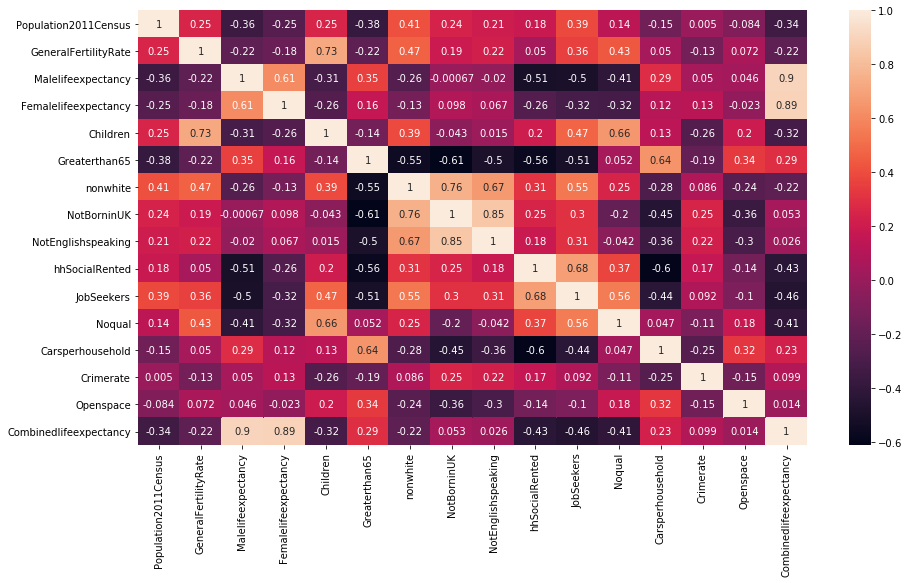

In [67]:
fig, ax = plt.subplots(figsize=(15,8))     
sns.heatmap(scaled_data.corr(),annot=True,ax=ax)

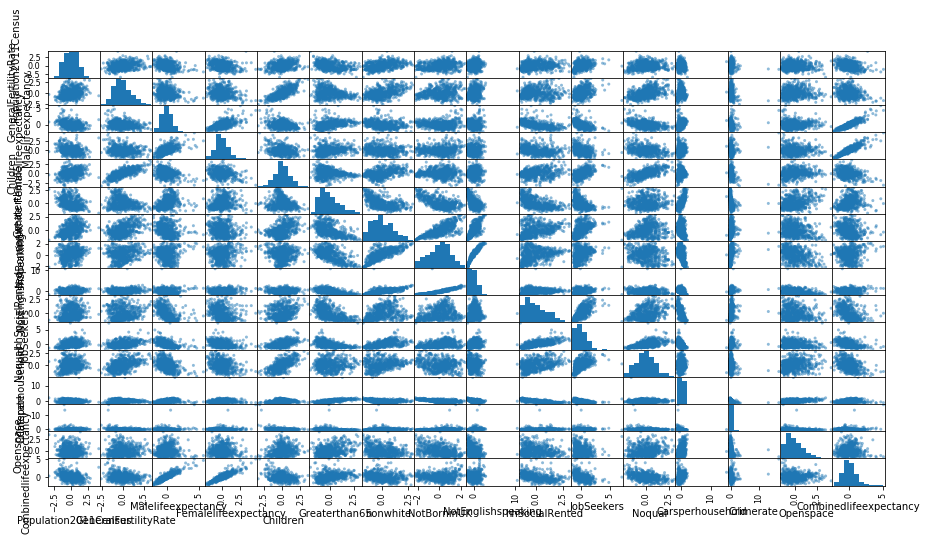

In [68]:
pd.plotting.scatter_matrix(scaled_data, figsize=(15,8));
# can we tidy the labels? it doesn't look straightforward... cf. https://stackoverflow.com/questions/26975089/making-the-labels-of-the-scatterplot-vertical-and-horizontal-in-pandas/27033833

### Explore Spatial Distribution of Life Expectancies

In [69]:
# https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london
ward_shapes = gpd.read_file(os.path.join('shapefiles','London_Ward.shp'))
print(ward_shapes.shape)
ward_shapes.head(1)

(654, 8)


,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry
0,Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((516401.600 160201.800, 516407.300 16..."


In [70]:
geo_districts = ward_shapes.merge(total_df.reset_index().rename(columns={'District':'BOROUGH'}),on='BOROUGH')

In [71]:
total_df.columns

Index(['Wardname', 'Population2011Census', 'GeneralFertilityRate',
       'Malelifeexpectancy', 'Femalelifeexpectancy', 'Children',
       'Greaterthan65', 'nonwhite', 'NotBorninUK', 'NotEnglishspeaking',
       'District', 'Ward', 'PopPlusDistrict', 'Wardcode', 'hhSocialRented',
       'JobSeekers', 'Noqual', 'Carsperhousehold', 'Crimerate', 'Openspace',
       'Districtcode', 'Combinedlifeexpectancy'],
      dtype='object')

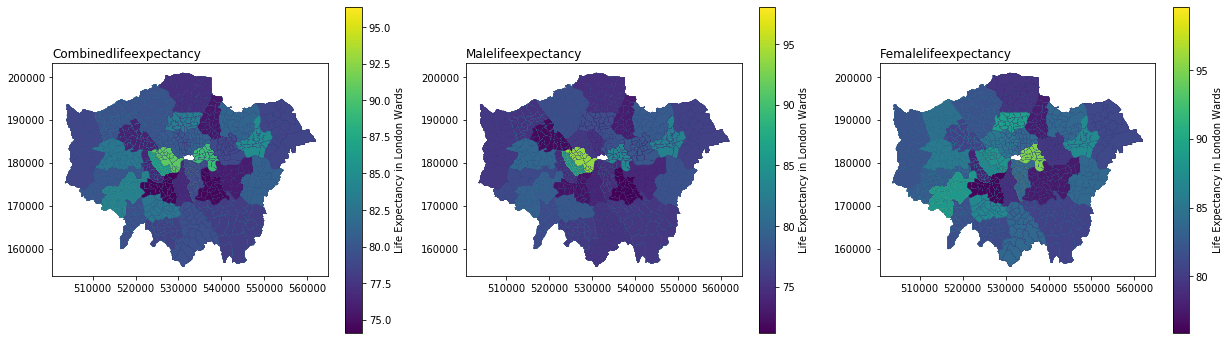

In [72]:
compare = ['Combinedlifeexpectancy','Malelifeexpectancy', 'Femalelifeexpectancy']

fig, axs = plt.subplots(1,len(compare),figsize=(21,6))

for i in range(len(compare)):
    ax=axs[i]
    geo_districts.plot(compare[i],\
                       ax=ax,\
                       legend=True,\
                       legend_kwds={
                                    'label': "Life Expectancy in London Wards",
                                    'orientation': "vertical"}
                        )
    ax.set_title(compare[i], loc='left')

### Explore Effect of Reducing Dimensionality

In [73]:
#Fitting the PCA algorithm with our Data
filled_scaled_data = scaled_data.fillna(0)
predictors = filled_scaled_data.drop(columns=['Combinedlifeexpectancy'])\
                                .drop(columns=['Malelifeexpectancy'])\
                                .drop(columns=['Femalelifeexpectancy'])
pca = PCA().fit(filled_scaled_data)

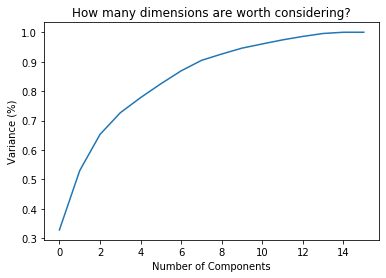

In [74]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('How many dimensions are worth considering?')
plt.show()

## Use Linear Regression to Predict Life-Expectancy

### Extract Best Explanatory Variables

We can use [mlxtend](http://rasbt.github.io/mlxtend/)'s ExhaustiveFeatureSelector to select the most explanatory predictive subsets of a given size.

In [75]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS # http://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector/
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm

In [76]:
lr = LinearRegression()

For the sake of efficiency, we will iterate over the various possiblities we are interested in, and store our results in `dicts` (ie. {'key':'value'}).

In [77]:
version = ['Combined','Male','Female']
efs = {}
y = {}
best = {}
for i in range(3):
    efs[version[i]] = {}
    best[version[i]] = {}
    y[version[i]] = filled_scaled_data[f'{version[i]}lifeexpectancy']

In [78]:
max_features = 8

for i in range(len(version)):
    for j in range(1, max_features+1):

        efs[version[i]][j] = EFS(lr, 
               min_features=1,
               max_features=j,
               scoring='neg_mean_squared_error',
               print_progress=False,
               cv=5)
    #      time[i] = %timeit -o efs[i].fit(X,y,custom_feature_names=cols)
        efs[version[i]][j].fit(predictors, y[version[i]], custom_feature_names=predictors.columns)
        best[version[i]][j] = efs[version[i]][j].best_feature_names_

In [79]:
for i in range(len(version)):
    print(version[i],best[version[i]])

Combined {1: ('JobSeekers',), 2: ('Greaterthan65', 'Noqual'), 3: ('Population2011Census', 'hhSocialRented', 'Noqual'), 4: ('Population2011Census', 'nonwhite', 'NotBorninUK', 'hhSocialRented'), 5: ('Population2011Census', 'Greaterthan65', 'nonwhite', 'NotBorninUK', 'hhSocialRented'), 6: ('Population2011Census', 'Greaterthan65', 'nonwhite', 'NotBorninUK', 'hhSocialRented', 'Noqual'), 7: ('Population2011Census', 'Children', 'Greaterthan65', 'nonwhite', 'NotBorninUK', 'hhSocialRented', 'Noqual'), 8: ('Population2011Census', 'Children', 'Greaterthan65', 'nonwhite', 'NotBorninUK', 'hhSocialRented', 'Noqual')}
Male {1: ('hhSocialRented',), 2: ('Greaterthan65', 'Noqual'), 3: ('Population2011Census', 'hhSocialRented', 'Noqual'), 4: ('Population2011Census', 'nonwhite', 'NotBorninUK', 'hhSocialRented'), 5: ('Population2011Census', 'Greaterthan65', 'nonwhite', 'NotBorninUK', 'hhSocialRented'), 6: ('Population2011Census', 'Greaterthan65', 'nonwhite', 'NotBorninUK', 'hhSocialRented', 'Noqual'), 7: (

### Find Linear Coefficients

We then use [statsmodels](https://www.statsmodels.org/stable/index.html)' `formula.api` to find the corresponding linear coefficients and $ R^2 $ values for those subsets.

In [80]:
formula = {}
for i in range(len(version)):
    formula[version[i]] = {}

for i in range(len(version)):
    for j in range(1, max_features+1):
        sum = ''
        for k, predictor in enumerate(best[version[i]][j]):
            if k == 0:
                sum = f'Q("{predictor}")'
            else:
                sum = f'{sum} + Q("{predictor}")'

        formula[version[i]][j] = f'Q("{version[i]}lifeexpectancy") ~ {sum} '

In [81]:
formula

{'Combined': {1: 'Q("Combinedlifeexpectancy") ~ Q("JobSeekers") ',
  2: 'Q("Combinedlifeexpectancy") ~ Q("Greaterthan65") + Q("Noqual") ',
  3: 'Q("Combinedlifeexpectancy") ~ Q("Population2011Census") + Q("hhSocialRented") + Q("Noqual") ',
  4: 'Q("Combinedlifeexpectancy") ~ Q("Population2011Census") + Q("nonwhite") + Q("NotBorninUK") + Q("hhSocialRented") ',
  5: 'Q("Combinedlifeexpectancy") ~ Q("Population2011Census") + Q("Greaterthan65") + Q("nonwhite") + Q("NotBorninUK") + Q("hhSocialRented") ',
  6: 'Q("Combinedlifeexpectancy") ~ Q("Population2011Census") + Q("Greaterthan65") + Q("nonwhite") + Q("NotBorninUK") + Q("hhSocialRented") + Q("Noqual") ',
  7: 'Q("Combinedlifeexpectancy") ~ Q("Population2011Census") + Q("Children") + Q("Greaterthan65") + Q("nonwhite") + Q("NotBorninUK") + Q("hhSocialRented") + Q("Noqual") ',
  8: 'Q("Combinedlifeexpectancy") ~ Q("Population2011Census") + Q("Children") + Q("Greaterthan65") + Q("nonwhite") + Q("NotBorninUK") + Q("hhSocialRented") + Q("Noqu

In [82]:
lm = {}
lm_df = {}
coefs = {}
r_squared = {}
new_dicts = [lm, lm_df, coefs, r_squared]
for i in range(len(version)):
    for j in range(len(new_dicts)):
        new_dicts[j][version[i]] = {}

In [83]:
new_dicts

[{'Combined': {}, 'Male': {}, 'Female': {}},
 {'Combined': {}, 'Male': {}, 'Female': {}},
 {'Combined': {}, 'Male': {}, 'Female': {}},
 {'Combined': {}, 'Male': {}, 'Female': {}}]

In [84]:
for i in range(len(version)):
    for j in range(1, max_features+1):

        lm[version[i]][j] = sm.ols(formula[version[i]][j], filled_scaled_data)\
           .fit()
        lm_df[version[i]][j] = pd.DataFrame(lm[version[i]][j].summary().tables[1])[:][[0,1]]
        coefs[version[i]][j] = lm_df[version[i]][j].set_index(0)

In [89]:
table = {}
for i in range(len(version)):
    table[version[i]] = []

In [90]:
table

{'Combined': [], 'Male': [], 'Female': []}

In [92]:
for i in range(len(version)):
    for j in range(1, max_features+1):
        table[version[i]].append({j: coefs[version[i]][j]})

In [93]:
for i in range(len(version)):
    for j in range(1, max_features+1):
        r_squared[version[i]][j] = lm[version[i]][j].rsquared

In [94]:
r_squared

{'Combined': {1: 0.20871763875972305,
  2: 0.2638507542320174,
  3: 0.31714921198381674,
  4: 0.3536731445709089,
  5: 0.3670424082918323,
  6: 0.37802151533353534,
  7: 0.3792699253484717,
  8: 0.3792699253484717},
 'Male': {1: 0.25916524546378883,
  2: 0.31176890667387547,
  3: 0.3797876168895563,
  4: 0.4073149677239327,
  5: 0.42194634452567903,
  6: 0.4316918331884604,
  7: 0.433936916549019,
  8: 0.43431600541961257},
 'Female': {1: 0.0993051057870038,
  2: 0.1458500783140052,
  3: 0.16929686540425304,
  4: 0.19312653785811118,
  5: 0.2018096450984116,
  6: 0.20853745149817848,
  7: 0.20853745149817848,
  8: 0.20853745149817848}}

In [ ]:
stop